### Import libraries

In [1]:
import sys
sys.path.append("..")
from model import classic_model, combined_model, experimental_model, losses, grapher
from data import data_generation, batch_creator, gp_kernels, gp_priors
from helpers import helpers, plotter, masks
from keras.callbacks import ModelCheckpoint
from inference import infer
import tensorflow as tf; import keras
import time

Using TensorFlow backend.


In [2]:
save_dir = '/Users/omernivron/Downloads/GPT'

In [3]:
pad_pos_tr, pad_pos_te, pad_y_fren_tr, pad_y_fren_te, _, df_te = data_generation.data_generator_for_gp_mimick_gpt(150, ordered = False, same_x = True)

# goes with check 61
np.save('/Users/omernivron/Downloads/pad_pos_tr', pad_pos_tr)

np.save('/Users/omernivron/Downloads/pad_pos_te', pad_pos_te)

np.save('/Users/omernivron/Downloads/pad_y_fren_tr', pad_y_fren_tr)

np.save('/Users/omernivron/Downloads/pad_y_fren_te', pad_y_fren_te)

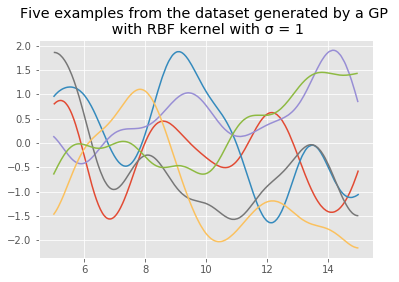

In [4]:
plotter.plot_examples(pad_pos_tr, pad_y_fren_tr)

In [5]:
train_step, test_step, loss_object, train_loss, test_loss, m_tr, m_te = grapher.build_graph()

In [6]:
batch_pos_tr, batch_tar_tr, _ = batch_creator.fake_batch(pad_pos_tr, pad_y_fren_tr, batch_s=1)
batch_pos_tr1 = batch_pos_tr[:, :-1]
batch_pos_tr_current = batch_pos_tr[:, 1:]

In [7]:
# batch_pos_tr, batch_tar_tr, _ = batch_creator.create_batch_gp_mim_2(pad_pos_tr, pad_y_fren_tr, batch_s=1)
# batch_pos_tr1 = batch_pos_tr[:, :-1]
# batch_pos_tr_current = batch_pos_tr[:, 1:]

Already exists
Initializing from scratch.
combined_mask_pos:  Tensor("Maximum:0", shape=(2, 600, 600), dtype=float32)
pos_mask:  Tensor("strided_slice_4:0", shape=(2, 599, 599), dtype=float32)
q_x:  Tensor("decoder/wq/BiasAdd:0", shape=(2, 600, 32), dtype=float64)
k_x:  Tensor("decoder/wk/BiasAdd:0", shape=(2, 600, 32), dtype=float64)
v_y:  Tensor("decoder/wv/BiasAdd:0", shape=(2, 599, 32), dtype=float64)
mask:  Tensor("strided_slice_4:0", shape=(2, 599, 599), dtype=float32)
matmul_qk before filter:  Tensor("decoder/qk:0", shape=(2, 600, 600), dtype=float64)
matmul_qk:  Tensor("decoder/strided_slice_2:0", shape=(2, 599, 599), dtype=float64)
nl_qk after mask:  Tensor("decoder/add:0", shape=(2, 599, 599), dtype=float64)
tar_attn1:  Tensor("decoder/MatMul:0", shape=(2, 599, 32), dtype=float64)
current_position:  Tensor("decoder/strided_slice_4:0", shape=(2, 599, 1), dtype=float64)
Tensor("decoder/Squeeze:0", shape=(2, 599, 2), dtype=float64)
Tensor("truediv_1:0", shape=(), dtype=float64)


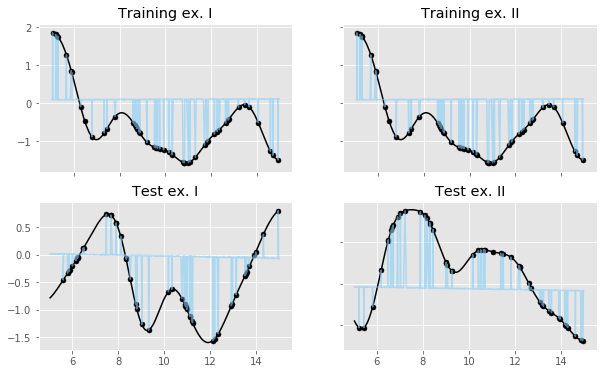

Epoch 0 batch 0 train Loss 0.7506 test Loss 0.6287 with training MSE metric 1.0984 and testing MSE metric 1.0828


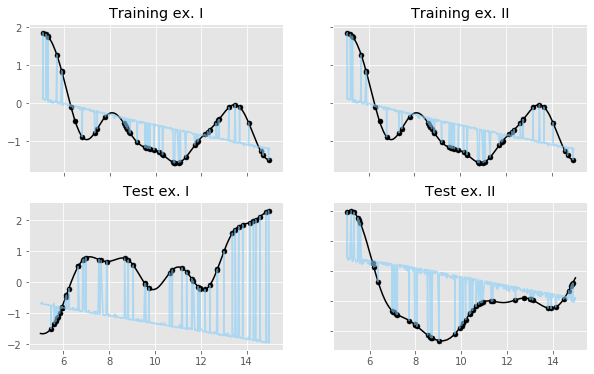

Epoch 0 batch 300 train Loss 0.2470 test Loss 1.2272 with training MSE metric 0.4941 and testing MSE metric 2.3774


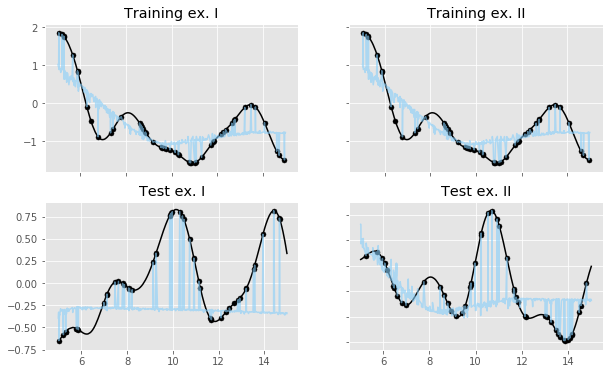

Epoch 0 batch 600 train Loss 0.0759 test Loss 0.9783 with training MSE metric 0.2490 and testing MSE metric 1.1774


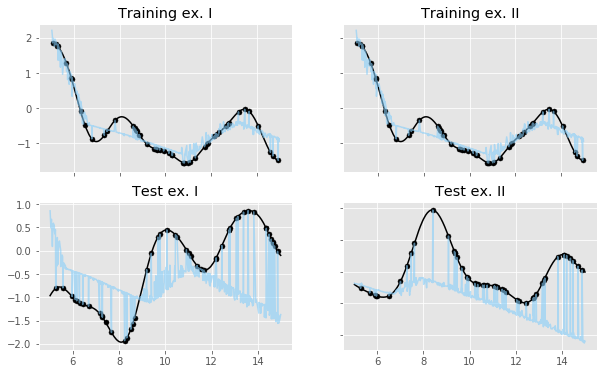

Epoch 0 batch 900 train Loss -0.2071 test Loss 7.4984 with training MSE metric 0.0807 and testing MSE metric 4.2008


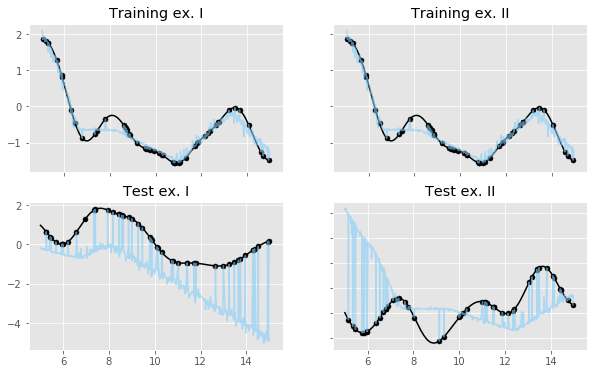

Epoch 0 batch 1200 train Loss -0.4113 test Loss 26.6897 with training MSE metric 0.0359 and testing MSE metric 6.8887
Time taken for 1 epoch: 46.19075012207031 secs



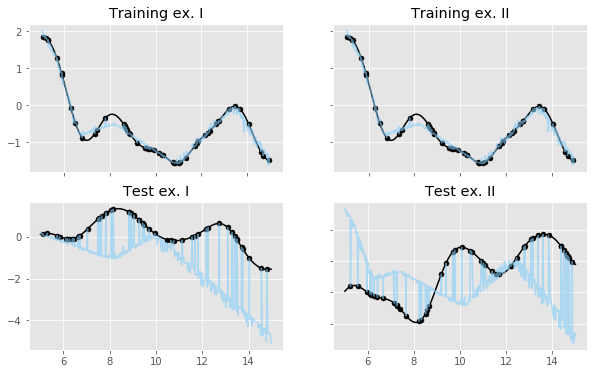

Epoch 1 batch 0 train Loss -0.6353 test Loss 52.8423 with training MSE metric 0.0149 and testing MSE metric 5.6213


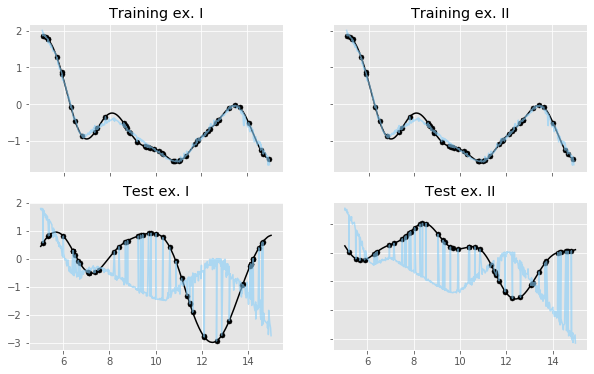

Epoch 1 batch 300 train Loss -0.8278 test Loss 100.4578 with training MSE metric 0.0072 and testing MSE metric 4.1104


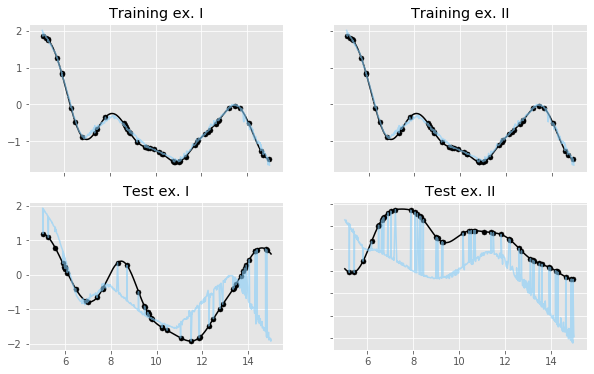

Epoch 1 batch 600 train Loss -0.9519 test Loss 157.7834 with training MSE metric 0.0046 and testing MSE metric 3.2870


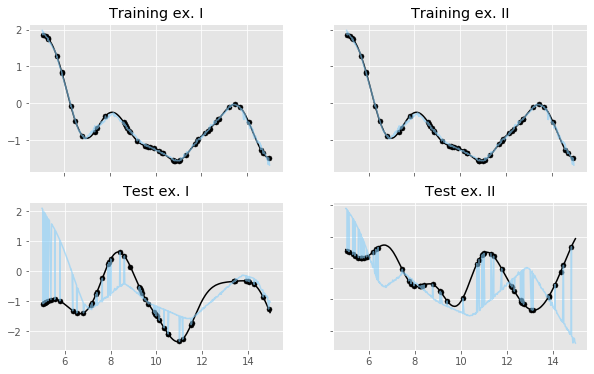

Epoch 1 batch 900 train Loss -1.1315 test Loss 222.6321 with training MSE metric 0.0025 and testing MSE metric 2.8831


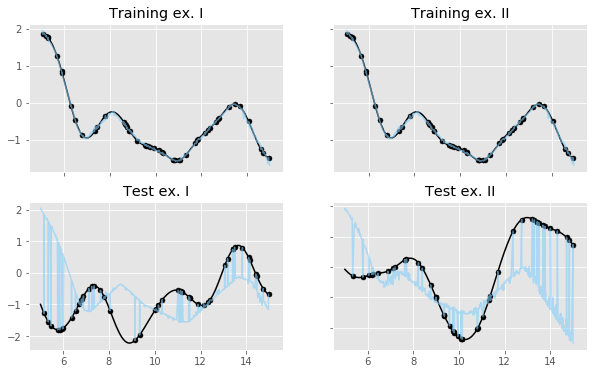

Epoch 1 batch 1200 train Loss -1.1863 test Loss 236.4668 with training MSE metric 0.0020 and testing MSE metric 2.6465
Time taken for 1 epoch: 40.050657987594604 secs



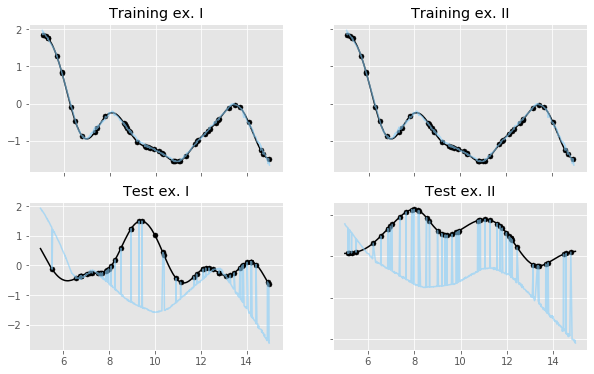

Epoch 2 batch 0 train Loss -1.2425 test Loss 291.1133 with training MSE metric 0.0017 and testing MSE metric 2.5291


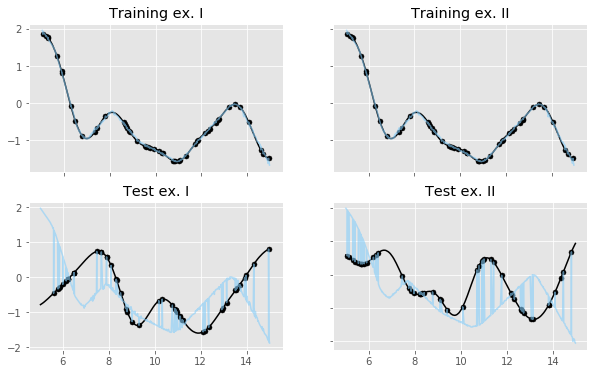

Epoch 2 batch 300 train Loss -1.3902 test Loss 616.5989 with training MSE metric 0.0014 and testing MSE metric 2.4443


In [ ]:
if __name__ == '__main__':
    writer = tf.summary.create_file_writer(save_dir + '/logs/')
    optimizer_c = tf.keras.optimizers.Adam(3e-4)
    decoder = experimental_model.Decoder(32); tf.random.set_seed(443)   
    EPOCHS = 25; batch_s  = 64; run = 100; step = 0
#     num_batches = int(pad_y_fren_tr.shape[0] / batch_s)
    num_batches = 1500
    ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer = optimizer_c, net = decoder)
    main_folder = "/Users/omernivron/Downloads/GPT/ckpt/check_"
    folder = main_folder + str(run); helpers.mkdir(folder)
    manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=3)
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")
    
    with writer.as_default():
        for epoch in range(EPOCHS):

            start = time.time()

            for batch_n in range(num_batches):
                m_tr.reset_states(); train_loss.reset_states()
                m_te.reset_states(); test_loss.reset_states()
#                 batch_pos_tr, batch_tar_tr, _ = batch_creator.create_batch_gp_mim_2(pad_pos_tr, pad_y_fren_tr, batch_s=64)
#                 batch_pos_tr1 = batch_pos_tr[:, :-1]
#                 batch_pos_tr_current = batch_pos_tr[:, 1:]
                pred, pred_log, weights, names = train_step(decoder, optimizer_c, train_loss, m_tr, batch_pos_tr, batch_tar_tr)
                
                if batch_n % 300 == 0:
#                     plotter.sample_plot_w_training(batch_pos_tr_current[1, :], batch_tar_tr[1, 1:], pred[1, :], title = 'training progress')
                    pos_te_current = pad_pos_te[:, 1:]
                    pred_te, pred_log_te = test_step(decoder, test_loss, m_te, pad_pos_te[:500, :], pad_y_fren_te[:500, :])
                    plotter.follow_training_plot(batch_pos_tr_current, batch_tar_tr[:, 1:], pred, pos_te_current[:500, :], pad_y_fren_te[:500, 1:], pred_te)
                    helpers.print_progress(epoch, batch_n, train_loss.result(), test_loss.result(), m_tr.result(), m_te.result())
                    helpers.tf_summaries(run, step, train_loss.result(), test_loss.result(), m_tr.result(), m_te.result(), weights, names)
                    manager.save()
                step += 1
                ckpt.step.assign_add(1)

            print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))